<a href="https://colab.research.google.com/github/PKpacheco/superv_ml_assignment/blob/main/svm_Paola_Katherine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Supervised Machine Learning - Support Vector Machine:
#### Paola Katherine Pacheco
#### Hockey Analysis using NHL data

# Executive Summary

The purpose of this case study is to predict the  total of points for an NHL hockey player based on the features: weight, height, hall of fame, position and body mass index.
All data comes from the official NHL page.

\
During the data cleaning process, columns that did not influence the prediction were deleted: nationality, state, province, draft round, country, year of draft, overall, date of birth, city of birth, first season and player name.

In addition, the variables were converted: weight, height, number of points and number of assistances from object to integer to generate the `points_per_game` variable and calculate the total points divided by the total number of games played.

To facilitate the classification, a range of points based on points per game was created, from a to e, being `range_a` best range and `range_e` worst performance

\
Graphs were plotted for all players comparing BMI and total points in addition to comparison graphs by position, where we can see weight, height, bmi, hall of fame by position.

\
We trained Support Vector Machine (SVM) models using the NHL dataset using differents hyperparameters to find the best model. 
After evaluating all the models using metrics such:  accuracy, F1 score, recall, and precision metrics, we found that the best model was an SVM with C=500 and kernel=Poly, which achieved an accuracy of 80% on the validation set and 73.33% on the test set.

# Preprocessing

In [78]:
# NHL Dataset
# NHL Data 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [79]:
#read bio info csv
bio_info_url ="https://raw.githubusercontent.com/PKpacheco/superv_ml_assignment/main/bio_info_nhl.csv"
df= pd.read_csv(bio_info_url, encoding = "utf-8")

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Player      1000 non-null   object
 1   S/C         1000 non-null   object
 2   Pos         1000 non-null   object
 3   DOB         1000 non-null   object
 4   Birth City  1000 non-null   object
 5   S/P         1000 non-null   object
 6   Ctry        1000 non-null   object
 7   Ntnlty      1000 non-null   object
 8   Ht          1000 non-null   object
 9   Wt          1000 non-null   object
 10  Draft Yr    1000 non-null   object
 11  Round       1000 non-null   object
 12  Overall     1000 non-null   object
 13  1st Season  1000 non-null   int64 
 14  HOF         1000 non-null   object
 15  GP          1000 non-null   object
 16  G           1000 non-null   int64 
 17  A           1000 non-null   object
 18  P           1000 non-null   object
dtypes: int64(2), object(17)
memory usage: 148.6+ KB


In [81]:
df.head()

,Player,S/C,Pos,DOB,Birth City,S/P,Ctry,Ntnlty,Ht,Wt,Draft Yr,Round,Overall,1st Season,HOF,GP,G,A,P
0,Glenn Anderson,L,R,1960-10-02,Vancouver,BC,CAN,CAN,73,190,1979,4,69,19801981,Y,"1,129",498,601,"1,099"
1,George Armstrong,R,R,1930-07-06,Skead,ON,CAN,CAN,73,184,--,--,--,19491950,Y,59,7,18,25
2,Dave Andreychuk,R,L,1963-09-29,Hamilton,ON,CAN,CAN,76,225,1982,1,16,19821983,Y,"1,639",640,698,"1,338"
3,Andy Bathgate,R,R,1932-08-28,Winnipeg,MB,CAN,CAN,72,180,--,--,--,19521953,Y,76,15,29,44
4,Johnny Bucyk,L,L,1935-05-12,Edmonton,AB,CAN,CAN,72,215,--,--,--,19551956,Y,567,244,348,592


In [82]:
df = df.rename(columns={
    "Player": "player",
    "S/C": "skater_shoots_goalie_catches",
    "Birth City": "birth_city",
    "S/P": "state_province",
    "Pos": "position",
    "Ht": "height", 
    "Wt": "weight", 
    "HOF": "hall_fame", 
    "Draft Yr": "draft_year",
    "1st Season": "first_season",
    "GP": "games_played", 
    "G": "Goal",
    "A": "assist",
    "P": "points"
    })
df.head()

,player,skater_shoots_goalie_catches,position,DOB,birth_city,state_province,Ctry,Ntnlty,height,weight,draft_year,Round,Overall,first_season,hall_fame,games_played,Goal,assist,points
0,Glenn Anderson,L,R,1960-10-02,Vancouver,BC,CAN,CAN,73,190,1979,4,69,19801981,Y,"1,129",498,601,"1,099"
1,George Armstrong,R,R,1930-07-06,Skead,ON,CAN,CAN,73,184,--,--,--,19491950,Y,59,7,18,25
2,Dave Andreychuk,R,L,1963-09-29,Hamilton,ON,CAN,CAN,76,225,1982,1,16,19821983,Y,"1,639",640,698,"1,338"
3,Andy Bathgate,R,R,1932-08-28,Winnipeg,MB,CAN,CAN,72,180,--,--,--,19521953,Y,76,15,29,44
4,Johnny Bucyk,L,L,1935-05-12,Edmonton,AB,CAN,CAN,72,215,--,--,--,19551956,Y,567,244,348,592


The positions we found are:


*   Left Wing
*   Right Wing 
*   Center
*   Defensemen

We  need to consider that depending on the position of each player, their total points should vary. A defensemen will definitely have less points since his position is not responsible for shoots

In [83]:
# list all positions
df['position'].unique()

array(['R', 'L', 'C', 'D'], dtype=object)

## Remove data with no influence on the output


Let's remove fields that we will not use as features because they have no influence on the total points:
* Natinalty
* State province
* Round
* Country
* Draft Year
* Overall
* Date of Birth
* birth city
* first season
* Skater Shoots and Goalie Catches
* Player Name

In [84]:
'''remove unecessay data, Natinalty, State province, Round, Country, draft year, 
   overall,date of birth, birth city, first season '''
 
df.drop([
    'player',
    'Ntnlty',
    'state_province',
    'Round', 
    'Ctry', 
    'draft_year', 
    'Overall', 
    'DOB', 
    'birth_city', 
    'first_season',
    'skater_shoots_goalie_catches'
    ], axis=1, inplace=True)


In [85]:
df.tail()


,position,height,weight,hall_fame,games_played,Goal,assist,points
995,D,68,173,N,25,2,3,5
996,R,71,200,N,1,0,0,0
997,C,72,180,N,47,2,6,8
998,D,69,205,N,477,36,171,207
999,L,70,160,N,112,22,43,65


## Organize the data

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   position      1000 non-null   object
 1   height        1000 non-null   object
 2   weight        1000 non-null   object
 3   hall_fame     1000 non-null   object
 4   games_played  1000 non-null   object
 5   Goal          1000 non-null   int64 
 6   assist        1000 non-null   object
 7   points        1000 non-null   object
dtypes: int64(1), object(7)
memory usage: 62.6+ KB


We have columns ( weight, height, assist, points) that should have as value , int64 ,but they are as object. \
We need to treat and modify these data\
for all the object columns we change to string

In [87]:
# convert points to a integer
df['points'] = df['points'].str.replace(',', '').astype(float)
df['points'] = df['points'].astype(int)
df.head()

,position,height,weight,hall_fame,games_played,Goal,assist,points
0,R,73,190,Y,"1,129",498,601,1099
1,R,73,184,Y,59,7,18,25
2,L,76,225,Y,"1,639",640,698,1338
3,R,72,180,Y,76,15,29,44
4,L,72,215,Y,567,244,348,592


In [88]:
# convert assist to a integer

df['assist'] = df['assist'].str.replace(',', '').astype(float)
df['assist']  = df['assist'].astype(int)
df.head()

,position,height,weight,hall_fame,games_played,Goal,assist,points
0,R,73,190,Y,"1,129",498,601,1099
1,R,73,184,Y,59,7,18,25
2,L,76,225,Y,"1,639",640,698,1338
3,R,72,180,Y,76,15,29,44
4,L,72,215,Y,567,244,348,592


In [89]:
# convert games_played to a integer

df['games_played'] = df['games_played'].str.replace(',', '').astype(float)
df['games_played'] = df['games_played'].astype(int)
df.head()

,position,height,weight,hall_fame,games_played,Goal,assist,points
0,R,73,190,Y,1129,498,601,1099
1,R,73,184,Y,59,7,18,25
2,L,76,225,Y,1639,640,698,1338
3,R,72,180,Y,76,15,29,44
4,L,72,215,Y,567,244,348,592


In [90]:
# convert weight to a integer and remove rows with non int values
df.drop(df[df.weight == '--'].index, inplace=True)


df['weight'] = df['weight'].str.replace(',', '').astype(float)
df['weight'] =df['weight'].astype(int)
df.head()

,position,height,weight,hall_fame,games_played,Goal,assist,points
0,R,73,190,Y,1129,498,601,1099
1,R,73,184,Y,59,7,18,25
2,L,76,225,Y,1639,640,698,1338
3,R,72,180,Y,76,15,29,44
4,L,72,215,Y,567,244,348,592


In [91]:
# convert height to a integer and remove rows with non int values
df.drop(df[df.height == '--'].index, inplace=True)

df['height'] = df['height'].str.replace(',', '').astype(float)
df['height'] = df['height'].astype(int)
df.head()

,position,height,weight,hall_fame,games_played,Goal,assist,points
0,R,73,190,Y,1129,498,601,1099
1,R,73,184,Y,59,7,18,25
2,L,76,225,Y,1639,640,698,1338
3,R,72,180,Y,76,15,29,44
4,L,72,215,Y,567,244,348,592


In [92]:
# convert object to string for easy operations

df['position'] = df['position'].astype('string')
df['hall_fame'] = df['hall_fame'].astype('string')

df.head()

,position,height,weight,hall_fame,games_played,Goal,assist,points
0,R,73,190,Y,1129,498,601,1099
1,R,73,184,Y,59,7,18,25
2,L,76,225,Y,1639,640,698,1338
3,R,72,180,Y,76,15,29,44
4,L,72,215,Y,567,244,348,592


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   position      999 non-null    string
 1   height        999 non-null    int64 
 2   weight        999 non-null    int64 
 3   hall_fame     999 non-null    string
 4   games_played  999 non-null    int64 
 5   Goal          999 non-null    int64 
 6   assist        999 non-null    int64 
 7   points        999 non-null    int64 
dtypes: int64(6), string(2)
memory usage: 70.2 KB


We need to relate the total of goals, assists and points by the amount of games played

In [94]:
df.head()

,position,height,weight,hall_fame,games_played,Goal,assist,points
0,R,73,190,Y,1129,498,601,1099
1,R,73,184,Y,59,7,18,25
2,L,76,225,Y,1639,640,698,1338
3,R,72,180,Y,76,15,29,44
4,L,72,215,Y,567,244,348,592


In [95]:
# new variable points_per_game, total of points divided by games played

df['points_per_game'] = df['points'] / df['games_played']
df.head() 

,position,height,weight,hall_fame,games_played,Goal,assist,points,points_per_game
0,R,73,190,Y,1129,498,601,1099,0.973428
1,R,73,184,Y,59,7,18,25,0.423729
2,L,76,225,Y,1639,640,698,1338,0.816351
3,R,72,180,Y,76,15,29,44,0.578947
4,L,72,215,Y,567,244,348,592,1.044092


In [96]:
# create new variable bmi (body mass index), relation between weight and height

df['bmi'] = (df['weight']/(df['height']**2)* 703)
df.tail()


,position,height,weight,hall_fame,games_played,Goal,assist,points,points_per_game,bmi
995,D,68,173,N,25,2,3,5,0.200000,26.301687
996,R,71,200,N,1,0,0,0,0.000000,27.891291
997,C,72,180,N,47,2,6,8,0.170213,24.409722
998,D,69,205,N,477,36,171,207,0.433962,30.269901
999,L,70,160,N,112,22,43,65,0.580357,22.955102


###Creating range for the points

* range_e -->  0 - 0.40
* range_d -->  0.40 - 0.80
* range_c -->  0.80 - 1.2
* range_b -->  1.20 - 1.6
* range_a -->  1.60 - 2.0

In [97]:
min_points = df['points_per_game'].min()
max_points = df['points_per_game'].max()

print(min_points)
print(max_points)

0.0
1.921318090114324


In [98]:
# range_e = [0,0.40]
# range_d = [0.41, 0.80]
# range_c = [0.81, 1.2]
# range_b =[1.21, 1.6]
# range_a = [1.61, 2.0]

def label_ranges (row):
  if row['points_per_game']>=0.0 and row['points_per_game']<=0.40:
      return'range_e'
    
  if row['points_per_game']>0.4 and row['points_per_game']<=0.80:
      return 'range_d'

  if row['points_per_game']>0.8 and row['points_per_game']<=1.20:
      return 'range_c'

  if row['points_per_game']>1.20 and row['points_per_game']<=1.60:
      return 'range_b'

  if row['points_per_game']>1.60 and row['points_per_game']<=2.0:
      return 'range_a'

df['range_points'] = df.apply(lambda row: label_ranges(row), axis=1)
df['range_points'] = df['range_points'].astype('string')

df.head()

,position,height,weight,hall_fame,games_played,Goal,assist,points,points_per_game,bmi,range_points
0,R,73,190,Y,1129,498,601,1099,0.973428,25.064740,range_c
1,R,73,184,Y,59,7,18,25,0.423729,24.273222,range_d
2,L,76,225,Y,1639,640,698,1338,0.816351,27.384868,range_c
3,R,72,180,Y,76,15,29,44,0.578947,24.409722,range_d
4,L,72,215,Y,567,244,348,592,1.044092,29.156057,range_c


In [99]:
# check null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   position         999 non-null    string 
 1   height           999 non-null    int64  
 2   weight           999 non-null    int64  
 3   hall_fame        999 non-null    string 
 4   games_played     999 non-null    int64  
 5   Goal             999 non-null    int64  
 6   assist           999 non-null    int64  
 7   points           999 non-null    int64  
 8   points_per_game  999 non-null    float64
 9   bmi              999 non-null    float64
 10  range_points     999 non-null    string 
dtypes: float64(2), int64(6), string(3)
memory usage: 93.7 KB


# Plot Data

## Plots for all players
* BMI 
* Range of Points
* Hall of Fame
* Points vs Hall of Fame
* Points per game played

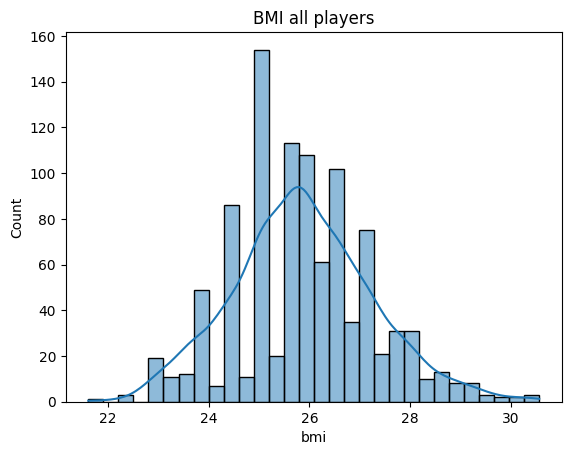

In [100]:
ax = sns.histplot(data = df, x = 'bmi', kde = True)
ax.set_title("BMI all players")
plt.show()

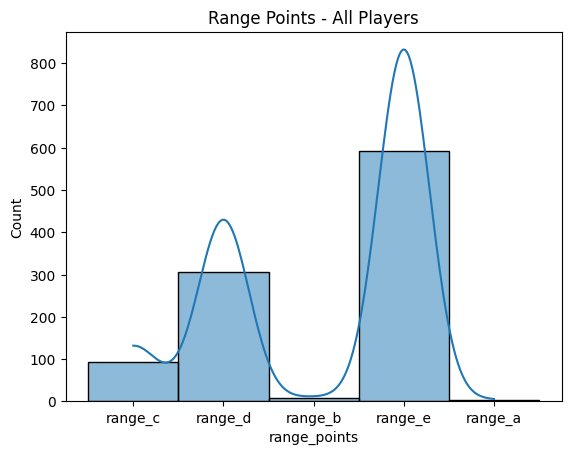

In [101]:
ax = sns.histplot(data = df, x = 'range_points', kde = True)
ax.set_title("Range Points - All Players")
plt.show()

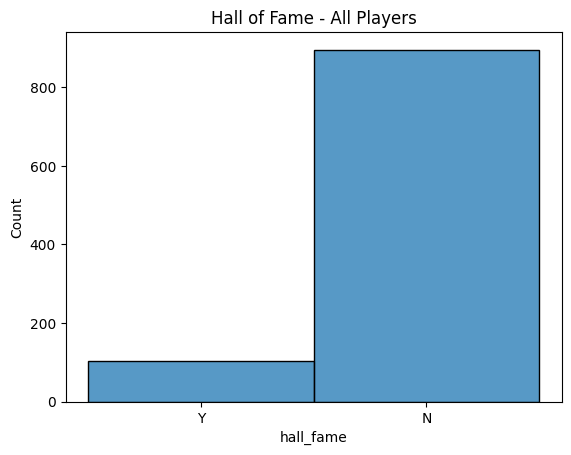

In [102]:
# plot hall of fame

ax = sns.histplot(data = df, x = 'hall_fame', )
ax.set_title("Hall of Fame - All Players")
plt.show()

<Axes: xlabel='points_per_game', ylabel='bmi'>

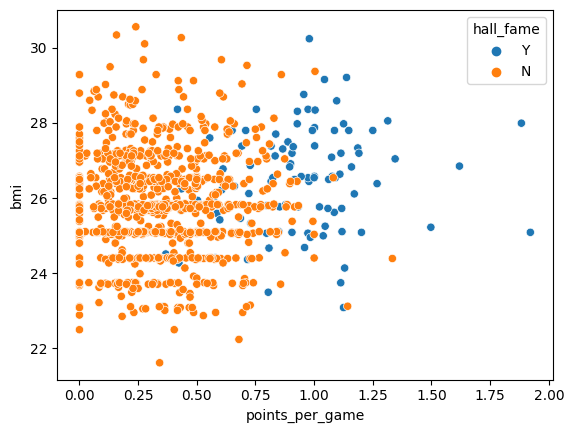

In [103]:
# plot hall of fame, bmi and points per game

sns.scatterplot(x = "points_per_game", y = "bmi", hue = "hall_fame", data = df)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f915064a430>,
 'caps': [<matplotlib.lines.Line2D at 0x7f915064a310>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f915064af10>],
 'medians': [<matplotlib.lines.Line2D at 0x7f918afdc7f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f918afdc640>],
 'means': []}

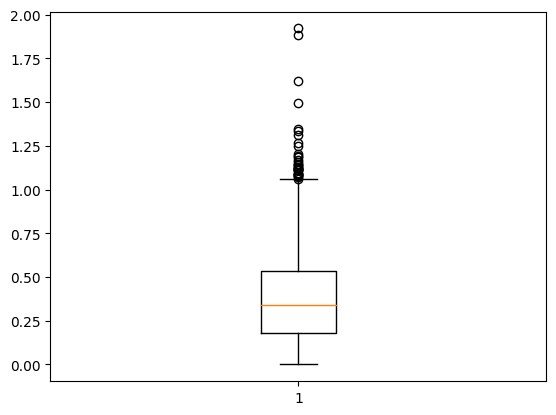

In [104]:
# we can see that most of players have between 0.25 and 0.5 points per game. 
plt.boxplot(df['points_per_game'])

## Plots for player's position

In [105]:
# create table for each position

df['position'].unique() #['R', 'L', 'C', 'D']

position_right_wing = (df["position"]=='R')
df_right_wing = df[position_right_wing]

position_left_wing = (df["position"]=='L') 
df_left_wing = df[position_left_wing]

position_center = (df["position"]=='C') 
df_center = df[position_center]

position_defensemen = (df["position"]=='D') 
df_defensemen  = df[position_defensemen]

In [106]:
df_right_wing.head()

,position,height,weight,hall_fame,games_played,Goal,assist,points,points_per_game,bmi,range_points
0,R,73,190,Y,1129,498,601,1099,0.973428,25.064740,range_c
1,R,73,184,Y,59,7,18,25,0.423729,24.273222,range_d
3,R,72,180,Y,76,15,29,44,0.578947,24.409722,range_d
8,R,72,186,Y,752,573,553,1126,1.497340,25.223380,range_b
14,R,70,185,Y,1232,608,592,1200,0.974026,26.541837,range_c


In [107]:
df_left_wing.head()

,position,height,weight,hall_fame,games_played,Goal,assist,points,points_per_game,bmi,range_points
2,L,76,225,Y,1639,640,698,1338,0.816351,27.384868,range_c
4,L,72,215,Y,567,244,348,592,1.044092,29.156057,range_c
5,L,72,195,Y,903,420,463,883,0.977852,26.443866,range_c
11,L,69,166,Y,68,10,15,25,0.367647,24.511237,range_e
26,L,74,200,Y,1160,239,262,501,0.431897,25.675676,range_d


In [108]:
df_center.head()

,position,height,weight,hall_fame,games_played,Goal,assist,points,points_per_game,bmi,range_points
6,C,75,205,Y,70,25,51,76,1.085714,25.620444,range_c
10,C,72,195,Y,240,60,136,196,0.816667,26.443866,range_c
12,C,71,186,Y,1318,260,403,663,0.503035,25.938901,range_d
15,C,70,185,Y,1068,343,821,1164,1.089888,26.541837,range_c
18,C,69,190,Y,1348,731,1040,1771,1.313798,28.055030,range_b


In [109]:
df_defensemen.head()

,position,height,weight,hall_fame,games_played,Goal,assist,points,points_per_game,bmi,range_points
7,D,76,220,Y,1270,240,537,777,0.611811,26.776316,range_d
9,D,72,223,Y,1612,410,1169,1579,0.979529,30.240934,range_c
13,D,72,191,Y,1651,185,763,948,0.574197,25.901427,range_d
16,D,72,205,Y,1409,396,1135,1531,1.086586,27.799961,range_c
21,D,73,215,Y,546,36,192,228,0.417582,28.362732,range_d


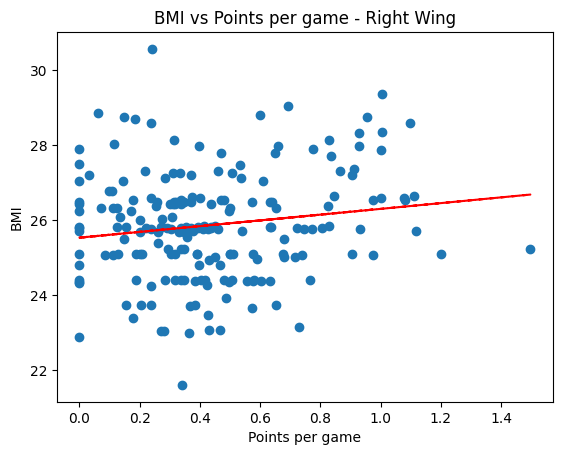

In [110]:
# plot relation between point per position and BMI
x = df_right_wing['points_per_game']
y = df_right_wing['bmi']

plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.title("BMI vs Points per game - Right Wing")
plt.ylabel("BMI")
plt.xlabel("Points per game")
plt.show()

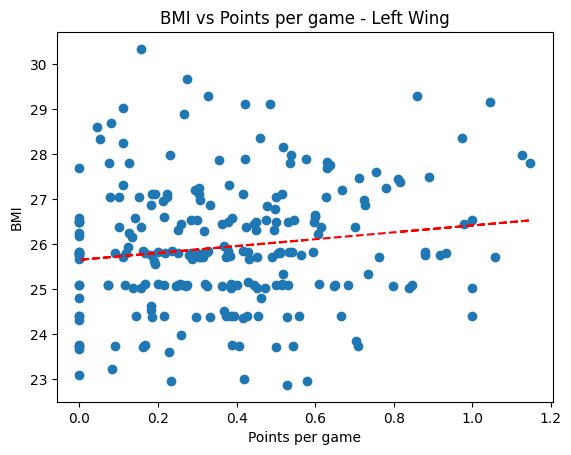

In [111]:
# plot relation between point per position and BMI
x = df_left_wing['points_per_game']
y = df_left_wing['bmi']

plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.title("BMI vs Points per game - Left Wing")
plt.ylabel("BMI")
plt.xlabel("Points per game")
plt.show()

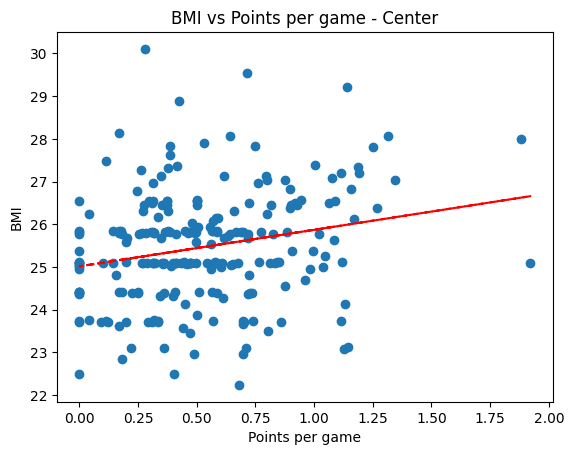

In [112]:
# plot relation between point per position and BMI
x = df_center['points_per_game']
y = df_center['bmi']

plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.title("BMI vs Points per game - Center")
plt.ylabel("BMI")
plt.xlabel("Points per game")
plt.show()

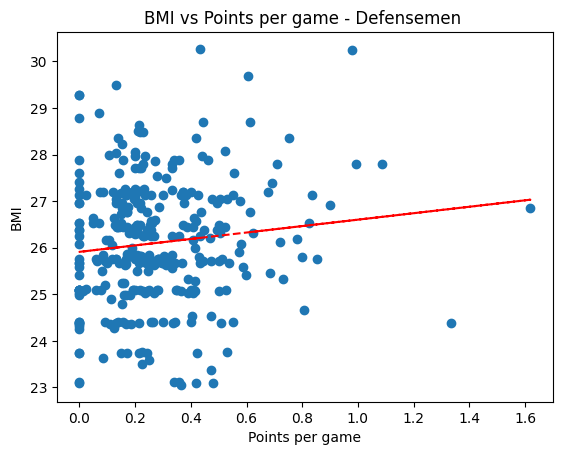

In [113]:
# plot relation between point per position and BMI
x = df_defensemen['points_per_game']
y = df_defensemen['bmi']

plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.title("BMI vs Points per game - Defensemen ")
plt.ylabel("BMI")
plt.xlabel("Points per game")
plt.show()

## AVG and Metrics by position

In [114]:
avg_defensemen_w = df_defensemen['weight'].mean()
avg_defensemen_h = df_defensemen['height'].mean()
avg_defensemen_bmi = df_defensemen['bmi'].mean()
avg_defensemen_ppg= df_defensemen['points_per_game'].mean()


print ('AVG weight for defensemen:',avg_defensemen_w,  '\n'
       'AVG height for defensemen:', avg_defensemen_h, '\n'
       'AVG BMI for defensemen:', avg_defensemen_bmi,  '\n'
       'AVG Points per Game for defensemen:', avg_defensemen_ppg

       )


AVG weight for defensemen: 195.97222222222223 
AVG height for defensemen: 72.64197530864197 
AVG BMI for defensemen: 26.102261604015506 
AVG Points per Game for defensemen: 0.2754878346239619


In [115]:
avg_center_w = df_center['weight'].mean()
avg_center_h = df_center['height'].mean()
avg_center_bmi = df_center['bmi'].mean()
avg_center_ppg= df_center['points_per_game'].mean()


print ('AVG weight for center:',avg_center_w,  '\n'
       'AVG height for center:', avg_center_h, '\n'
       'AVG BMI for center :', avg_center_bmi, '\n'
       'AVG Points per Game for center:', avg_center_ppg
       )


AVG weight for center: 184.10212765957448 
AVG height for center: 71.27659574468085 
AVG BMI for center : 25.460038516229147 
AVG Points per Game for center: 0.5209776526749132


In [116]:
avg_left_wing_w = df_left_wing['weight'].mean()
avg_left_wing_h = df_left_wing['height'].mean()
avg_left_wing_bmi = df_left_wing['bmi'].mean()
avg_left_wing_ppg= df_left_wing['points_per_game'].mean()


print ('AVG weight for left wing:',avg_left_wing_w,  '\n'
       'AVG height for left wing:', avg_left_wing_h, '\n'
       'AVG BMI for left wing:', avg_left_wing_bmi,  '\n'
       'AVG Points per Game for left wing:', avg_left_wing_ppg
)


AVG weight for left wing: 190.75105485232066 
AVG height for left wing: 71.88185654008439 
AVG BMI for left wing: 25.938828314379457 
AVG Points per Game for left wing: 0.3747452799203224


In [117]:
avg_right_wing_w = df_right_wing['weight'].mean()
avg_right_wing_h = df_right_wing['height'].mean()
avg_right_wing_bmi = df_right_wing['bmi'].mean()
avg_right_wing_ppg= df_right_wing['points_per_game'].mean()


print ('AVG weight for right wing:',avg_right_wing_w,  '\n'
       'AVG height for right wing:', avg_right_wing_h, '\n'
       'AVG BMI for right wing:', avg_right_wing_bmi,  '\n'
       'AVG Points per Game for right wing:', avg_right_wing_ppg

      )


AVG weight for right wing: 187.89655172413794 
AVG height for right wing: 71.44827586206897 
AVG BMI for right wing: 25.86863835371995 
AVG Points per Game for right wing: 0.4348740958991085


### Plot BMI by position

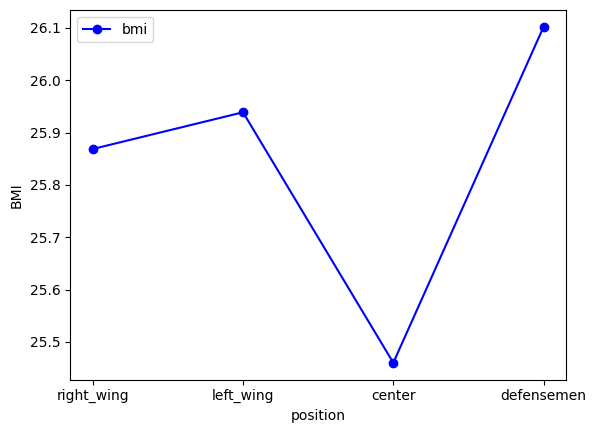

In [118]:
# bmi plot
label = ['right_wing',
         'left_wing',
         'center',
         'defensemen'
         ]

bmi = [
    avg_right_wing_bmi, 
    avg_left_wing_bmi,
    avg_center_bmi,
    avg_defensemen_bmi
          ]

plt.plot(label, bmi, color="blue", marker="o", label="bmi")

plt.xticks(range(0,4))
plt.ylabel("BMI")
plt.xlabel("position")

plt.legend()
plt.show() 


### Plot Points per game by position

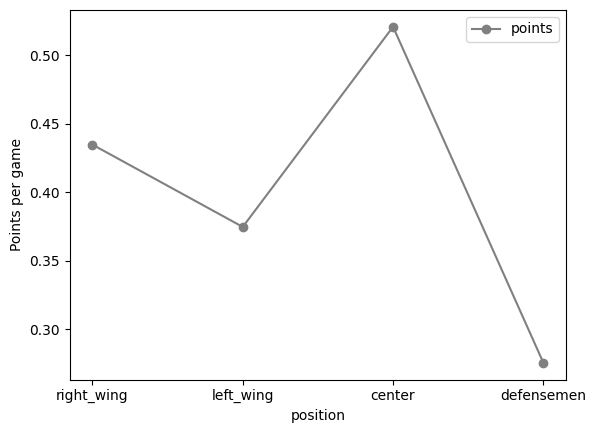

In [119]:
# points plot
label = ['right_wing',
         'left_wing',
         'center',
         'defensemen'
         ]

points = [avg_right_wing_ppg, 
          avg_left_wing_ppg,
          avg_center_ppg,
          avg_defensemen_ppg
          ]

plt.plot(label, points, color="grey", marker="o", label="points")

plt.xticks(range(0,4))
plt.ylabel("Points per game")
plt.xlabel("position")

plt.legend()
plt.show() 


### Plot Height by position

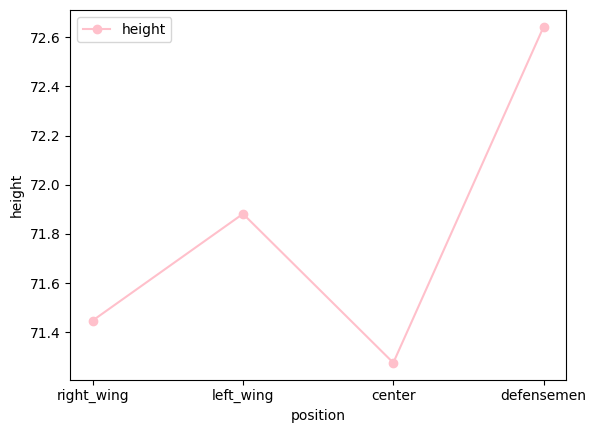

In [120]:
# points plot
label = ['right_wing',
         'left_wing',
         'center',
         'defensemen'
         ]

height = [avg_right_wing_h, 
          avg_left_wing_h,
          avg_center_h,
          avg_defensemen_h
          ]

plt.plot(label, height, color="pink", marker="o", label="height")

plt.xticks(range(0,4))
plt.ylabel("height")
plt.xlabel("position")

plt.legend()
plt.show() 

### Plot Weight by position

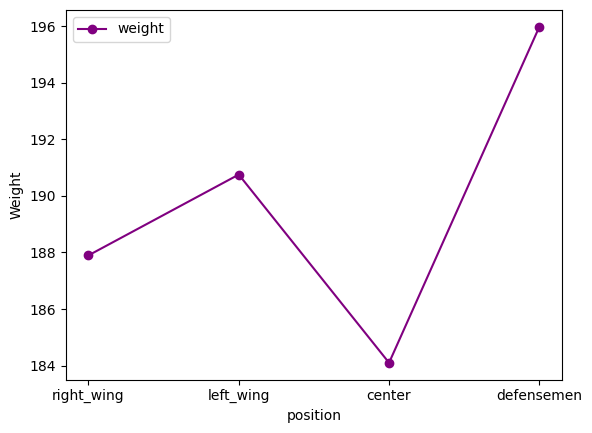

In [121]:
# points plot
label = ['right_wing',
         'left_wing',
         'center',
         'defensemen'
         ]

weight = [avg_right_wing_w, 
          avg_left_wing_w,
          avg_center_w,
          avg_defensemen_w
          ]

plt.plot(label, weight, color="purple", marker="o", label="weight")

plt.xticks(range(0,4))
plt.ylabel("Weight")
plt.xlabel("position")

plt.legend()
plt.show() 


### Plot ( Weight, Height, BMI and Points)




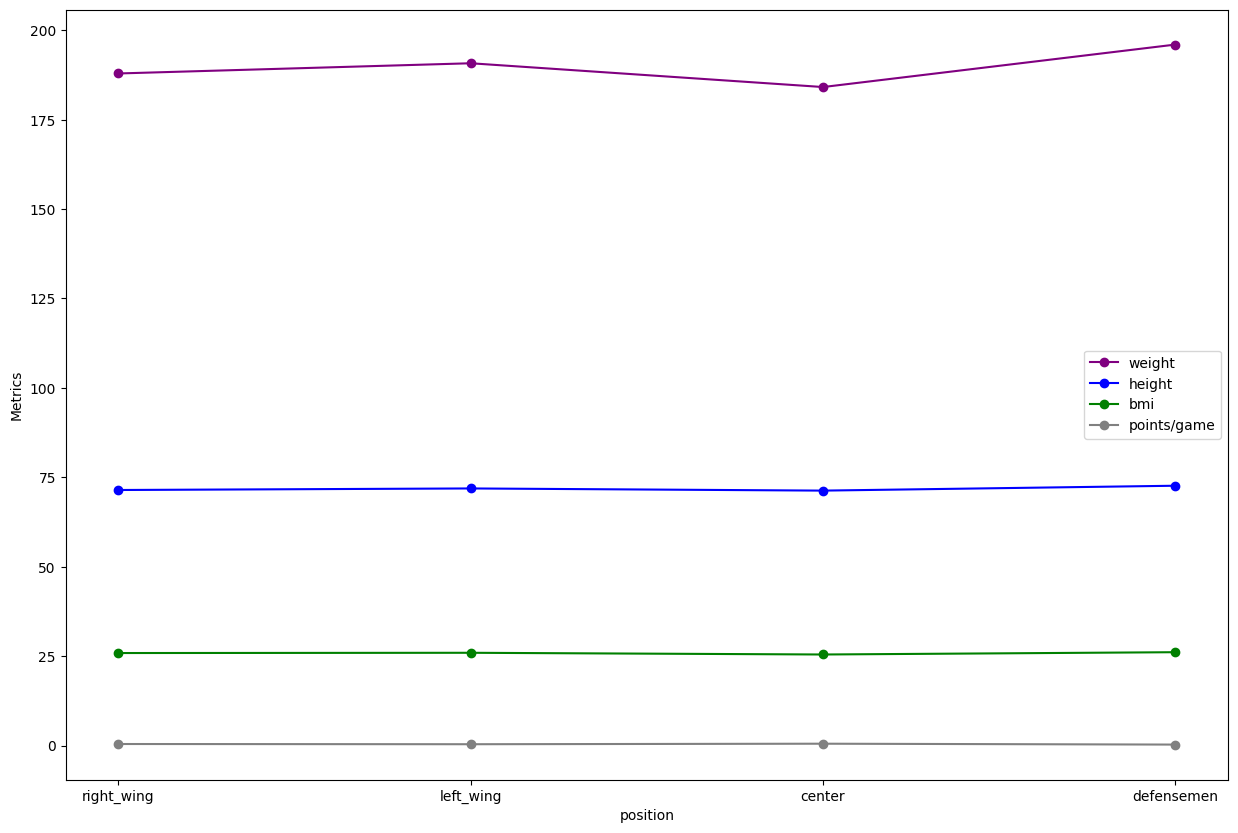

In [122]:

label = ['right_wing',
         'left_wing',
         'center',
         'defensemen'
         ]


weight = [avg_right_wing_w, 
          avg_left_wing_w,
          avg_center_w,
          avg_defensemen_w
          ]

height = [avg_right_wing_h, 
          avg_left_wing_h,
          avg_center_h,
          avg_defensemen_h
          ]

bmi = [avg_right_wing_bmi, 
       avg_left_wing_bmi,
       avg_center_bmi,
       avg_defensemen_bmi
       ]

ppg = [avg_right_wing_ppg, 
       avg_left_wing_ppg,
       avg_center_ppg,
       avg_defensemen_ppg
       ]

plt.figure(figsize=(15, 10))

plt.plot(label, weight, color="purple", marker="o", label="weight")
plt.plot(label, height, color="blue", marker="o", label="height")
plt.plot(label, bmi, color="green", marker="o", label="bmi")
plt.plot(label, ppg, color="grey", marker="o", label="points/game")

plt.xticks(range(0,4))

plt.ylabel("Metrics")

plt.xlabel("position")

plt.legend()
plt.show() 


# Conclusion After Plot

After analyzing and plotting some metrics, we were able to observe that most players have a BMI (body mass index) concentrated between 25 and 28. In addition to having an average of points per games played between 0.25 and 0.40

We also noticed that most of the athletes are in the **range_d** and **range_e** of points achieved by games, which is equivalent to [0.40 to 0.80] and [0.0 to 0.40] respectively.

It was observed that most players do not belong to the hall of fame, and those who do have a higher score per game.

After separating by position: center, defensemen, right and left wing. We observe that for the metrics weight, height, bmi and points per games we have the following results:

- defensemen players have higher averages for weight, height and bmi. 

- center have better metrics and higher averages for points per game played.

- Right and left wing players do not have better metrics in any of the analyzed features.


# Support Vector Machine(SVM)  

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   position         999 non-null    string 
 1   height           999 non-null    int64  
 2   weight           999 non-null    int64  
 3   hall_fame        999 non-null    string 
 4   games_played     999 non-null    int64  
 5   Goal             999 non-null    int64  
 6   assist           999 non-null    int64  
 7   points           999 non-null    int64  
 8   points_per_game  999 non-null    float64
 9   bmi              999 non-null    float64
 10  range_points     999 non-null    string 
dtypes: float64(2), int64(6), string(3)
memory usage: 93.7 KB


In [124]:
df['range_points'].unique()

<StringArray>
['range_c', 'range_d', 'range_b', 'range_e', 'range_a']
Length: 5, dtype: string

In [125]:
new_data = pd.DataFrame(df, columns = [
    'position', 
    'height', 
    'weight', 
    'hall_fame', 
    'points_per_game', 
    'bmi',
    'range_points'
    ])
new_data

,position,height,weight,hall_fame,points_per_game,bmi,range_points
0,R,73,190,Y,0.973428,25.064740,range_c
1,R,73,184,Y,0.423729,24.273222,range_d
2,L,76,225,Y,0.816351,27.384868,range_c
3,R,72,180,Y,0.578947,24.409722,range_d
4,L,72,215,Y,1.044092,29.156057,range_c
...,...,...,...,...,...,...,...
995,D,68,173,N,0.200000,26.301687,range_e
996,R,71,200,N,0.000000,27.891291,range_e
997,C,72,180,N,0.170213,24.409722,range_e
998,D,69,205,N,0.433962,30.269901,range_d


In [126]:
# import libraries
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

In [127]:
# encoding range_points, position and hall_fame

le = preprocessing.LabelEncoder()

new_data['range_points'] = le.fit_transform(new_data['range_points'])
new_data['position'] = le.fit_transform(new_data['position'])
new_data['hall_fame'] = le.fit_transform(new_data['hall_fame'])

new_data

,position,height,weight,hall_fame,points_per_game,bmi,range_points
0,3,73,190,1,0.973428,25.064740,2
1,3,73,184,1,0.423729,24.273222,3
2,2,76,225,1,0.816351,27.384868,2
3,3,72,180,1,0.578947,24.409722,3
4,2,72,215,1,1.044092,29.156057,2
...,...,...,...,...,...,...,...
995,1,68,173,0,0.200000,26.301687,4
996,3,71,200,0,0.000000,27.891291,4
997,0,72,180,0,0.170213,24.409722,4
998,1,69,205,0,0.433962,30.269901,3


In [128]:
# check rows and columns quantity
new_data.shape


(999, 7)

In [129]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   position         999 non-null    int64  
 1   height           999 non-null    int64  
 2   weight           999 non-null    int64  
 3   hall_fame        999 non-null    int64  
 4   points_per_game  999 non-null    float64
 5   bmi              999 non-null    float64
 6   range_points     999 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 62.4 KB


In [130]:
col_names = new_data.columns
col_names

Index(['position', 'height', 'weight', 'hall_fame', 'points_per_game', 'bmi',
       'range_points'],
      dtype='object')

In [131]:
# check distribution per points range
new_data['range_points'].value_counts()

4    591
3    305
2     93
1      7
0      3
Name: range_points, dtype: int64

In [132]:
round(new_data.describe(),2)

,position,height,weight,hall_fame,points_per_game,bmi,range_points
count,999.00,999.00,999.00,999.0,999.00,999.00,999.00
mean,1.41,71.90,190.30,0.1,0.39,25.86,3.48
std,1.06,1.95,14.13,0.3,0.29,1.38,0.72
min,0.00,66.00,155.00,0.0,0.00,21.62,0.00
25%,1.00,71.00,180.00,0.0,0.18,25.09,3.00
50%,1.00,72.00,190.00,0.0,0.34,25.80,4.00
75%,2.00,73.00,200.00,0.0,0.53,26.61,4.00
max,3.00,78.00,240.00,1.0,1.92,30.56,4.00


Text(0, 0.5, 'bmi')

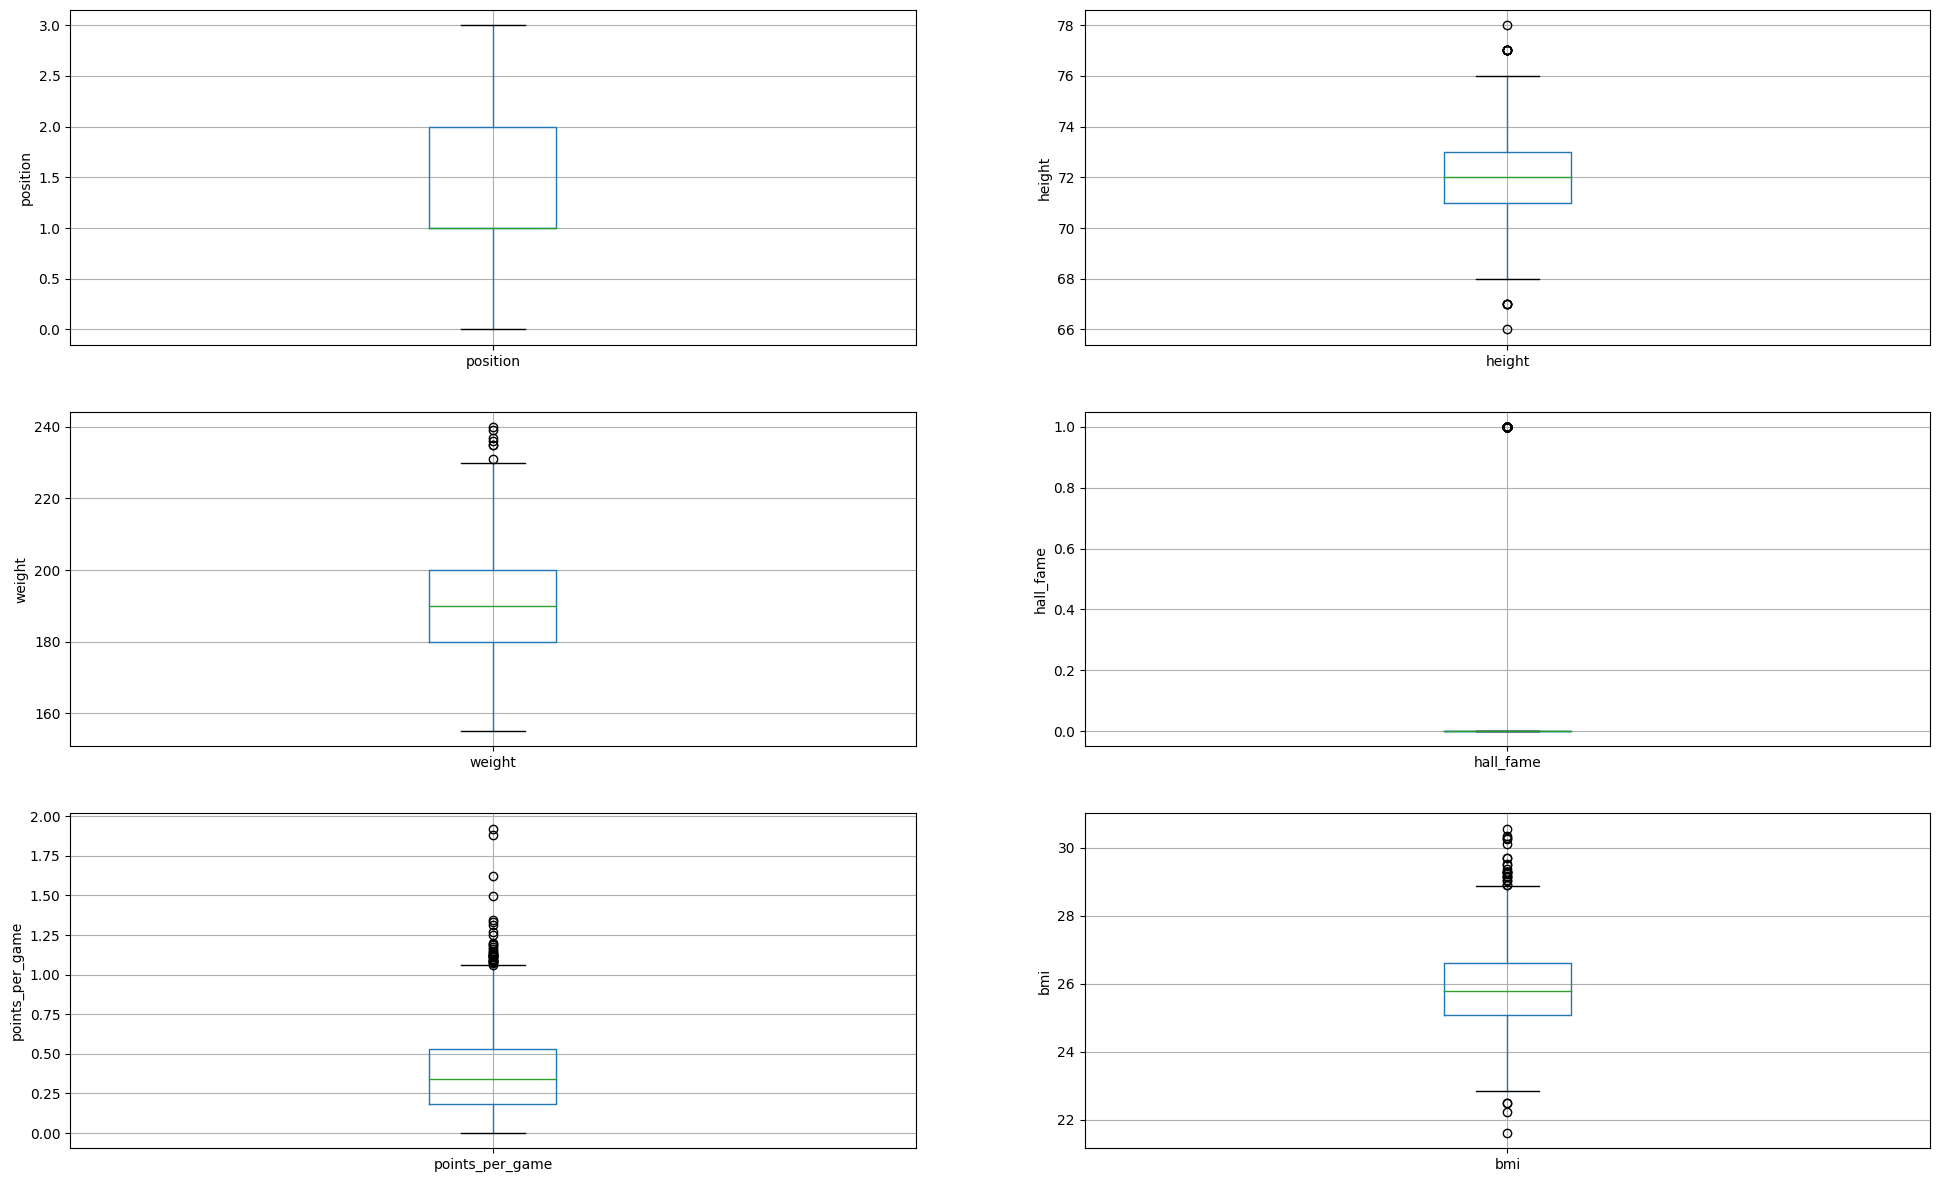

In [133]:
# check outliers
plt.figure(figsize=(24,20))


plt.subplot(4, 2, 1)
fig = new_data.boxplot(column='position')
fig.set_title('')
fig.set_ylabel('position')


plt.subplot(4, 2, 2)
fig = new_data.boxplot(column='height')
fig.set_title('')
fig.set_ylabel('height')


plt.subplot(4, 2, 3)
fig = new_data.boxplot(column='weight')
fig.set_title('')
fig.set_ylabel('weight')


plt.subplot(4, 2, 4)
fig = new_data.boxplot(column='hall_fame')
fig.set_title('')
fig.set_ylabel('hall_fame')


plt.subplot(4, 2, 5)
fig = new_data.boxplot(column='points_per_game')
fig.set_title('')
fig.set_ylabel('points_per_game')


plt.subplot(4, 2, 6)
fig = new_data.boxplot(column='bmi')
fig.set_title('')
fig.set_ylabel('bmi')


In [134]:
# target range_points variable
X = new_data.drop(['range_points'], axis=1)

y = new_data['range_points']

## Split Data

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Split the data into training and testing sets
X_train_test, X_test, y_train_test, y_test = train_test_split(X, y, test_size=0.3)

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_test, y_train_test, test_size=0.429)

# Print the sizes of the three sets
print(f'Training set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Testing set size: {len(X_test)}')


Training set size: 399
Validation set size: 300
Testing set size: 300


In [136]:
# check the size after split
X_train.shape, X_test.shape, X_val.shape


((399, 6), (300, 6), (300, 6))

In [137]:
# check columns
cols = X_train.columns
cols

Index(['position', 'height', 'weight', 'hall_fame', 'points_per_game', 'bmi'], dtype='object')

In [138]:
# import libraries 
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, 
                             precision_score,
                             recall_score, 
                             f1_score,
                             confusion_matrix,
                             roc_curve,
                             auc, 
                             fbeta_score,
                             classification_report
                             )

## One vs. one *OR* One vs. rest method 

The individual classification trains with a binary classifier for each n*(n-1)/2 pair of classes where n is the number of classes.

One-vers-rest classification trains a binary classifier for each class against all other classes, resulting in n classifiers for n classes. Despite being simpler, it may be less accurate in cases where the number of samples for each class is unbalanced.

In the case below with the data, we have the same results for both methods, and the result was not so good.


Validation, recall and F1 accuracy show numbers around 60, means 60% of data has good classification.

Apparently this is not  overfitting because the metrics are very close and we can see similar results.

Classification Report for Method:OneVsOneClassifier(estimator=SVC(decision_function_shape='ovo'))
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00        29
           3       0.00      0.00      0.00        91
           4       0.59      1.00      0.74       176

    accuracy                           0.59       300
   macro avg       0.12      0.20      0.15       300
weighted avg       0.34      0.59      0.43       300



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: 

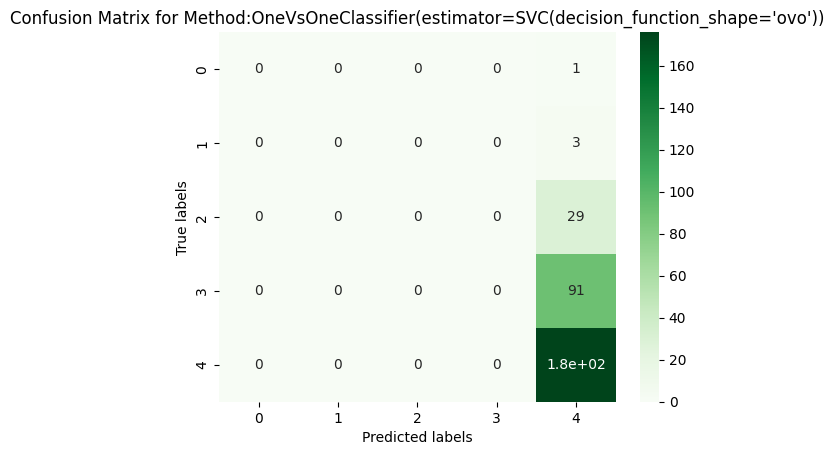

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: 

Classification Report for Method:OneVsRestClassifier(estimator=SVC())
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00        29
           3       0.00      0.00      0.00        91
           4       0.59      1.00      0.74       176

    accuracy                           0.59       300
   macro avg       0.12      0.20      0.15       300
weighted avg       0.34      0.59      0.43       300



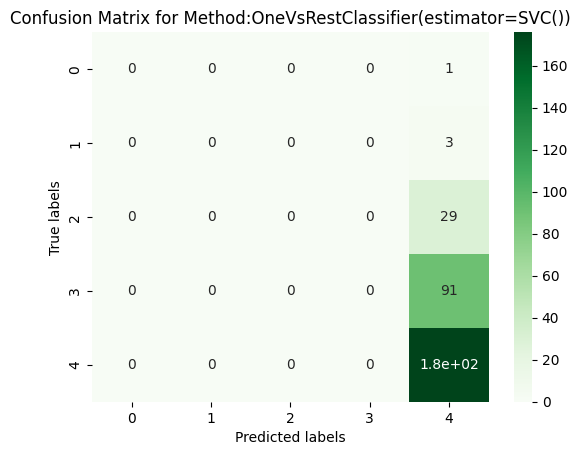

Method                                                              Validation Accuracy    Test Accuracy    Validation Accuracy    Test Precision
----------------------------------------------------------------  ---------------------  ---------------  ---------------------  ----------------
OneVsOneClassifier(estimator=SVC(decision_function_shape='ovo'))               0.586667         0.344178               0.586667          0.433838
OneVsRestClassifier(estimator=SVC())                                           0.586667         0.344178               0.586667          0.433838


In [139]:
# create table header
title = ["Method", "Validation Accuracy", "Test Accuracy",
         "Validation Accuracy","Test Precision",
         "Validation Recall", "Test Recall", 
         "Validation F1 score", "Test F1 score"]
table = []

# define values of Methods
method_o_vs_one = OneVsOneClassifier(SVC(decision_function_shape='ovo'))
method_o_vs_rest = OneVsRestClassifier(SVC(decision_function_shape='ovr'))
all_methods = [method_o_vs_one, method_o_vs_rest]

for m in range(len(all_methods)):
    svc = all_methods[m]

    # fit classifier to training set
    svc.fit(X_train, y_train)

    # predict using validation set
    y_val_pred = svc.predict(X_val)

    # calculate metrics for validation set
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, average='weighted')
    val_recall = recall_score(y_val, y_val_pred, average='weighted')
    val_f1 = fbeta_score(y_val, y_val_pred, average='weighted', beta=1)



    # add row to table
    row = [str(svc),  val_accuracy,
           val_precision,
           val_recall,
           val_f1]

    table.append(row)

    # print classification report for validation set
    print("=" * 80)
    print(f'Classification Report for Method:{all_methods[m]}\n', classification_report(y_val, y_val_pred))

    # create confusion matrix for validation set
    confusion_mat = confusion_matrix(y_val, y_val_pred)

    # create heatmap of the confusion matrix
    sns.heatmap(confusion_mat, annot=True, cmap='Greens')

    # plot confusion matrix
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix for Method:{all_methods[m]}')
    plt.show()
 
# print table
print(tabulate(table, headers=title))


## Different values for C parameter

- Find predictions using the validation set.
- Use the score() function to display the training/validation accuracy (for classification)
- Metrics : recall, precision, Fβ score
- Confusion matrix, ROC curve and AUC for the validation set.

The C parameter controls the distance between the decision boundary and the nearest data points, because of this it reduces the classification error.

If we put a low value for C we increase the margin but we may have an incorrect classification. 

If we put a high value we have a narrower margin, a better classification in the training with the training data but it can suffer overfiting.


Based on the metrics apparently C=5000 presents the best results with highest values for all the metrics. 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


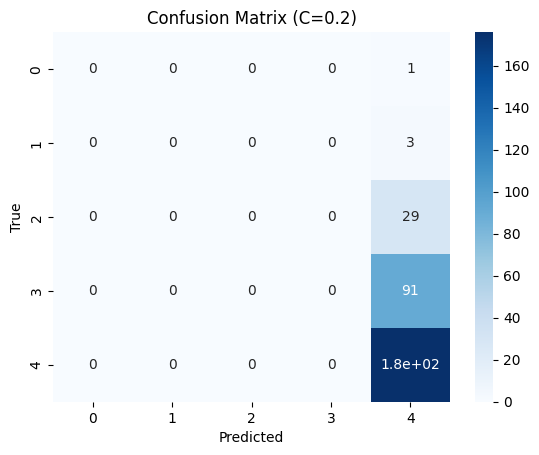

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


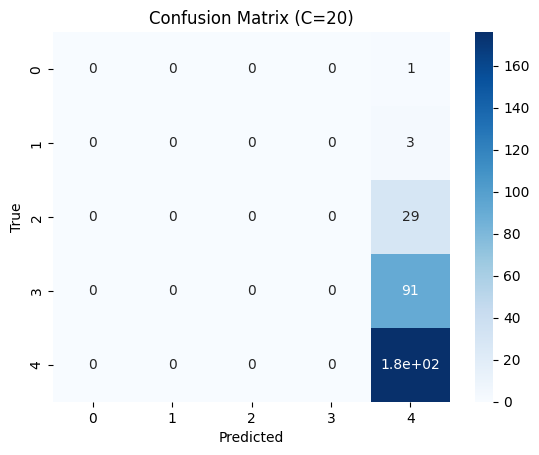

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


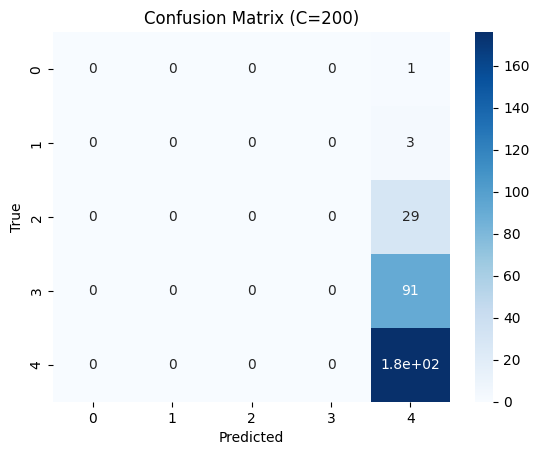

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


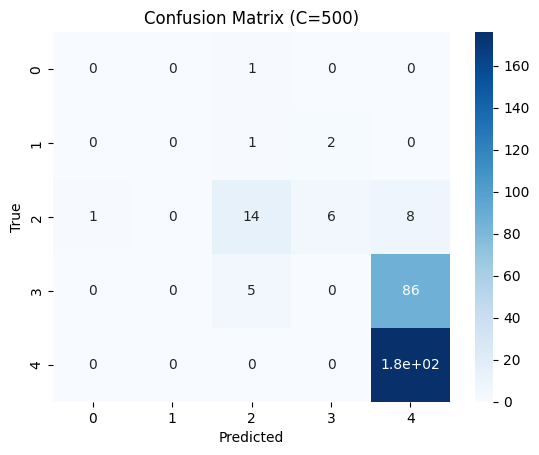

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


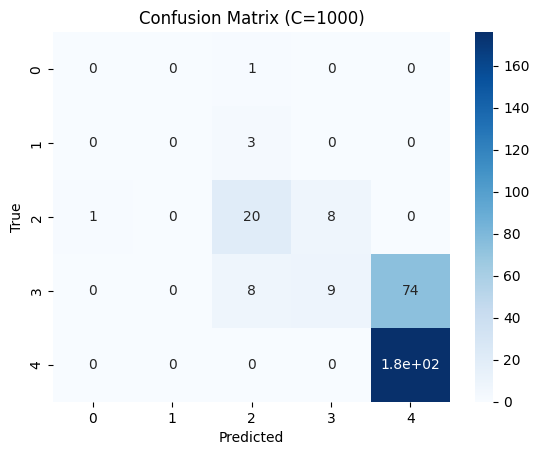

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


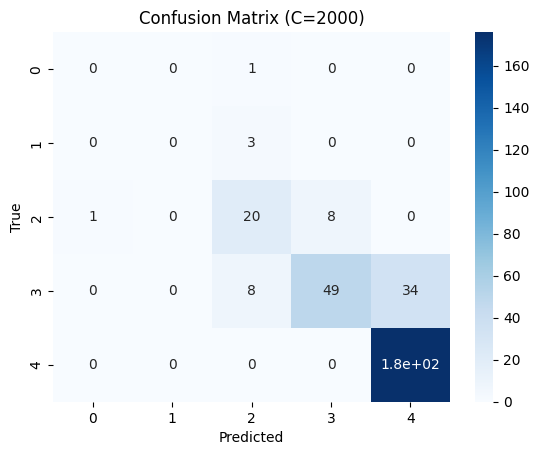

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


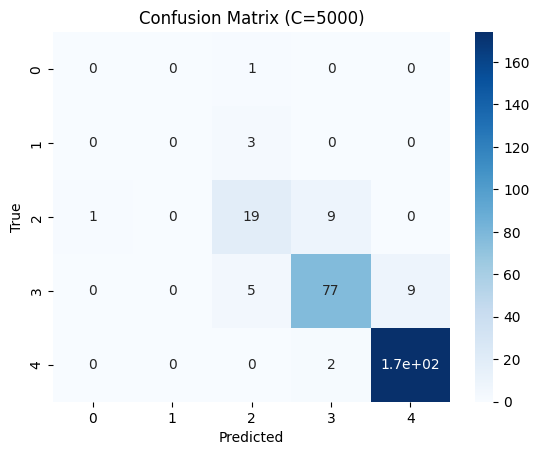

+------+---------------------+----------------------+---------------------+---------------------+
|  C   | Validation Accuracy | Validation Precision |  Validation Recall  | Validation F1 Score |
+------+---------------------+----------------------+---------------------+---------------------+
| 0.2  |  0.5866666666666667 | 0.11733333333333333  |         0.2         | 0.14789915966386555 |
|  20  |  0.5866666666666667 | 0.11733333333333333  |         0.2         | 0.14789915966386555 |
| 200  |  0.5866666666666667 | 0.11733333333333333  |         0.2         | 0.14789915966386555 |
| 500  |  0.6333333333333333 | 0.26370370370370366  | 0.29655172413793107 | 0.26984753363228703 |
| 1000 |  0.6833333333333333 | 0.37168235294117646  | 0.35771125426297845 |  0.3297390902793812 |
| 2000 |  0.8166666666666667 | 0.46454887218045116  |  0.4456233421750663 |  0.4459633931051581 |
| 5000 |         0.9         |  0.5008782201405152  | 0.49799252471666267 |  0.4992722387347432 |
+------+------------

In [140]:
params = {
    'C': [0.2, 20,  200, 500, 1000, 2000, 5000]
}

# Create a table to display the results
table = PrettyTable(['C',
                     'Validation Accuracy', 
                     'Validation Precision', 
                     'Validation Recall',
                     'Validation F1 Score',
                     ])

def combine_models(params, X_train, y_train, X_val, y_val):
    results = []
    # Combine hyperparameters and run an SVM for each option
    for C in params['C']:
      svc = SVC(C=C)
      # Train the model on the training set
      svc.fit(X_train, y_train)

      # Make predictions on the validation set 
      y_val_pred = svc.predict(X_val)


      # Calculate the performance metrics
      val_acc, val_prec, val_rec, val_f1 = calculate_metrics(y_val, y_val_pred)

      # Add the results to the table
      table.add_row([C, 
                      val_acc, 
                      val_prec, 
                      val_rec, 
                      val_f1,
                      ])
      # Display the confusion matrix
      display_confusion_matrix(y_val, y_val_pred,C)
    return results


def calculate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, prec, rec, f1


def display_confusion_matrix(y_true, y_pred, C):
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Plot the confusion matrix
    labels = sorted(list(set(y_true)))
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix (C={C})')
    plt.show()

#add lines to results and print table
results = combine_models(params, X_train, y_train, X_val, y_val)
for r in results:
    table.add_row(r)
print(table)


## Try differente kernel functions

Three different kernels were used: linear, RBF and polynomial.

- LINEAR <br> 
We use linear kernel when data can easily be separated by a hyperplane, classes can be separated.
When the data are not linearly separable, it is not a function with good results.

- RBF <br> 
For the RBF kernel, we set three different gamma values to try: 0,2, 20, and 200.
For the RBF kernel that it can combine multiple polynomial kernels multiple times of different degrees to project the non-linearly separable data into higher dimensional space so that it can be separable using a hyperplane.

- POLYNOMIAL<br> 
Also used for when the bounds are non-linear, the data has a high dimension. Basically is used in non-linear models


-----

We can see that the **polynomial** kernel works best for the data we have, since we have 0.97 accuracy, good test accuracy, recall and F1 on both sets, validation and test.

Secondly, the **linear** kernel also showed good results and we can assume that this data is linearly separable by a hyperplane.

The RBF kernel with Gamma=0.2 shows the biggest difference between the test and validation accuracy, it might be an indication for overfitting. 


Classification Report for kernel:rbf
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         3
           2       0.20      0.03      0.06        29
           3       0.43      0.22      0.29        91
           4       0.63      0.89      0.74       176

    accuracy                           0.59       300
   macro avg       0.25      0.23      0.22       300
weighted avg       0.52      0.59      0.53       300



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetr

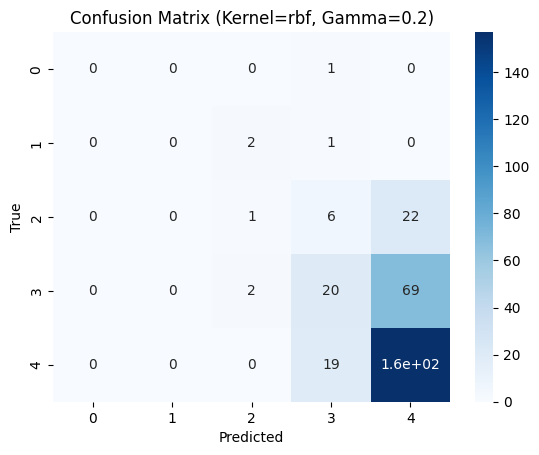

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetr

Classification Report for kernel:rbf
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         3
           2       0.50      0.03      0.06        29
           3       0.46      0.20      0.28        91
           4       0.61      0.90      0.73       176

    accuracy                           0.59       300
   macro avg       0.32      0.23      0.21       300
weighted avg       0.55      0.59      0.52       300



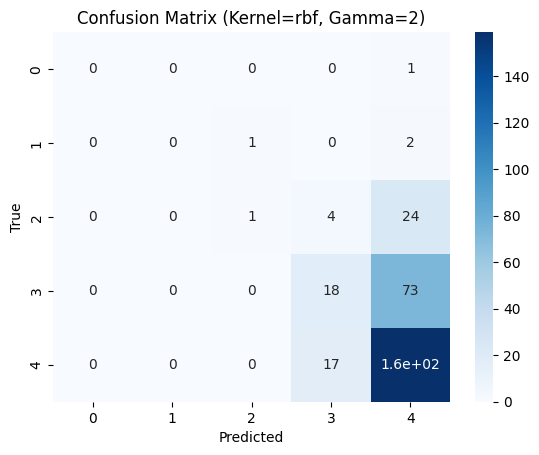

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetr

Classification Report for kernel:rbf
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         3
           2       1.00      0.03      0.07        29
           3       0.70      0.25      0.37        91
           4       0.62      0.94      0.75       176

    accuracy                           0.63       300
   macro avg       0.46      0.25      0.24       300
weighted avg       0.67      0.63      0.56       300



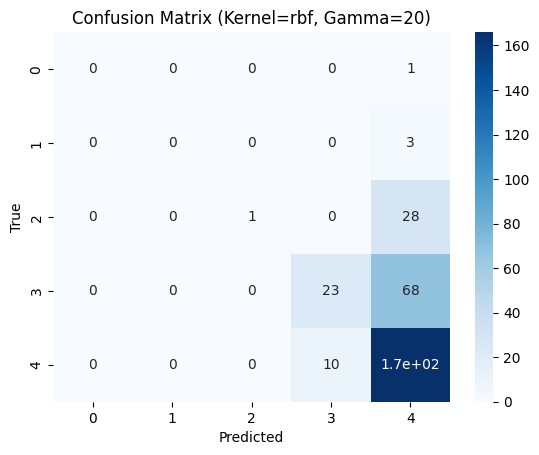

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for kernel:poly
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.67      0.67      0.67         3
           2       0.90      0.97      0.93        29
           3       0.95      0.96      0.95        91
           4       0.99      0.97      0.98       176

    accuracy                           0.96       300
   macro avg       0.70      0.71      0.71       300
weighted avg       0.96      0.96      0.96       300



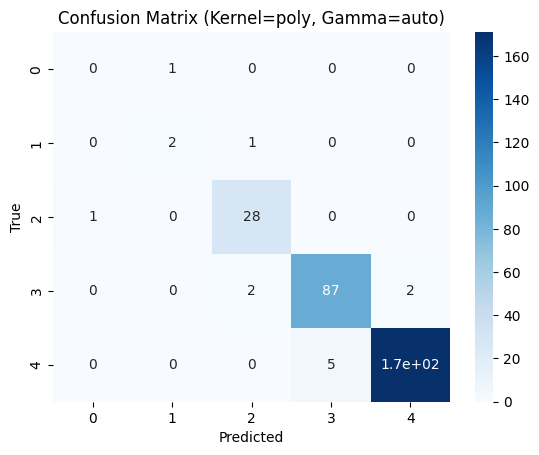

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: 

Classification Report for kernel:linear
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         3
           2       0.71      0.76      0.73        29
           3       0.90      0.92      0.91        91
           4       0.99      0.98      0.99       176

    accuracy                           0.93       300
   macro avg       0.52      0.53      0.53       300
weighted avg       0.92      0.93      0.93       300



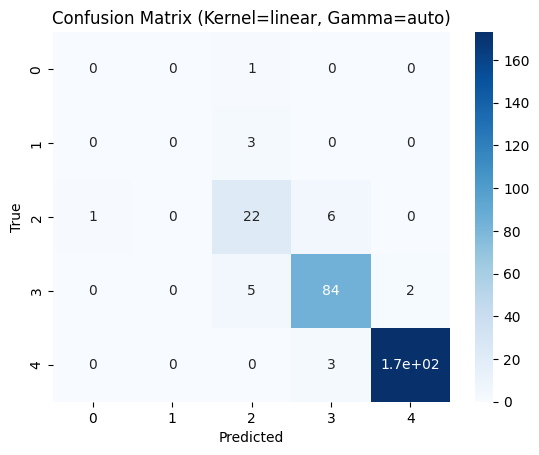

+--------+-------+---------------------+--------------------+-----------------------+----------------------+--------------------+---------------------+--------------------+---------------------+---------------------+
| Kernel | Gamma | Validation Accuracy |   Test Accuracy    |        diff_acc       | Validation Precision |   Test Precision   |  Validation Recall  |    Test Recall     | Validation F1 Score |    Test F1 Score    |
+--------+-------+---------------------+--------------------+-----------------------+----------------------+--------------------+---------------------+--------------------+---------------------+---------------------+
|  rbf   |  0.2  |  0.5933333333333334 | 0.5733333333333334 |  0.020000000000000018 |  0.2517192862045299  | 0.4021272945616744 |  0.2292616865892728 | 0.2723322379799377 |  0.2178489279222764 |  0.2561823966760709 |
|  rbf   |   2   |  0.5933333333333334 | 0.5666666666666667 |  0.026666666666666727 | 0.31508761508761507  | 0.4799389567147614 | 0.

In [141]:
params = {
    'kernel': ['rbf', 'poly', 'linear']
}

# Create a table to display the results
table = PrettyTable(['Kernel','Gamma',
                     'Validation Accuracy',   'Test Accuracy', 'diff_acc',
                     'Validation Precision',  'Test Precision',
                     'Validation Recall',     'Test Recall',
                     'Validation F1 Score',   'Test F1 Score',
                     ])


def combine_models(params, X_train, y_train, X_val, y_val):
    results = []
    # Combine hyperparameters and run an SVM for each option
    for kernel in params['kernel']:
        if kernel == 'rbf':
            gamma_values = [0.2, 2, 20]
        else:
            gamma_values = ['auto']
        for gamma in gamma_values:
            svc = SVC(kernel=kernel, gamma=gamma)

            # Train the model on the training set
            svc.fit(X_train, y_train)

            # Make predictions on the validation set and test set
            y_val_pred = svc.predict(X_val)
            y_test_pred = svc.predict(X_test)

            # Calculate the performance metrics
            val_acc, val_prec, val_rec, val_f1 = calculate_metrics(y_val, y_val_pred)
            test_acc, test_prec, test_rec, test_f1 = calculate_metrics(y_test, y_test_pred)
            diff_acc = val_acc - test_acc

            # Add the results to the table
            table.add_row([kernel, gamma, 
                            val_acc, test_acc, diff_acc,
                            val_prec,test_prec, 
                            val_rec,test_rec, 
                            val_f1, test_f1
                            ])

            class_rep = classification_report(y_val, y_val_pred)
            print(f'Classification Report for kernel:{kernel}\n', class_rep)
            print("=" * 80)
            # Display the confusion matrix
            display_confusion_matrix(y_val, y_val_pred, kernel, gamma)
    return results

def calculate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, prec, rec, f1


def display_confusion_matrix(y_true, y_pred, kernel, gamma):
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Plot the confusion matrix
    labels = sorted(list(set(y_true)))
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix (Kernel={kernel}, Gamma={gamma})')
    plt.show()

#add lines to results and print table
results = combine_models(params, X_train, y_train, X_val, y_val)
for r in results:
    table.add_row(r)
print(table)


## Best model

I decided to test 4 new models based on the responses of previous models.

We can see the best model is :
- C=5000
- kernel = Poly
However, this model has a low accuracy score, which means a problem in the classification of True values. For recall and accuracy, the values are also not the highest but overall have a good balance between the results.

----------------------------

- model_1 = SVC(kernel='rbf', range=2)
Has the worst performance of all 4 models, validation precision = 0.563 and F1=0.167

- model_2 = SVC(kernel='poly', C=0.2)
validation precision = 0.577 and F1 score = 0.146

- model_3 = SVC(kernel='rbf', range=5)
  validation precision = 0.6 F1 score = 0.227,

- model_4 = SVC(kernel='poly', C=5000)
It has the best performance among all models, validation precision = 0.927 and F1 score = 0.531, however it has a warning message informing that the price is poorly defined for some labels.



In [142]:
# Create the top 5  SVM models
model_1 = SVC(kernel='rbf', gamma=2)
model_2 = SVC(kernel='poly', C=0.2)
model_3 = SVC(kernel='rbf', gamma=5)
model_4 = SVC(kernel='poly', C=5000)

all_models = [model_1, model_2, model_3, model_4]

# Train and evaluate each model
for m in all_models:
    # Train the model on the training data
    m.fit(X_train, y_train)
    
    # evaluate the model on the validation set
    val_pred = m.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_pred)
    val_f1 = f1_score(y_val, val_pred, average='macro')
    val_recall = recall_score(y_val, val_pred, average='macro')
    val_precision = precision_score(y_val, val_pred, average='macro')

    # evaluate the model on the test set
    test_pred = m.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_pred)
    test_f1 = f1_score(y_test, test_pred, average='macro')
    test_recall = recall_score(y_test, test_pred, average='macro')
    test_precision = precision_score(y_test, test_pred, average='macro')

    # Print the model's validation and test scores
    print(f"Model: {m}")
    print(f"Validation Accuracy: {val_accuracy}")
    print(f"Validation F1 Score: {val_f1}")
    print(f"Validation Recall : {val_recall}")
    print(f"Validation Precision : {val_precision}")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test F1 Score: {test_f1}")
    print(f"Test Recall Score: {test_recall}")
    print(f"Test Precision Score: {test_precision}")
    print("=" * 50)




Model: SVC(gamma=2)
Validation Accuracy: 0.5933333333333334
Validation F1 Score: 0.21449473774279113
Validation Recall : 0.22713880946639567
Validation Precision : 0.31508761508761507
Test Accuracy: 0.5666666666666667
Test F1 Score: 0.24039969834087482
Test Recall Score: 0.2616417329643722
Test Precision Score: 0.4799389567147614
Model: SVC(C=0.2, kernel='poly')
Validation Accuracy: 0.5866666666666667
Validation F1 Score: 0.14789915966386555
Validation Recall : 0.2
Validation Precision : 0.11733333333333333
Test Accuracy: 0.59
Test F1 Score: 0.18553459119496857
Test Recall Score: 0.25
Test Precision Score: 0.1475
Model: SVC(gamma=5)
Validation Accuracy: 0.6333333333333333
Validation F1 Score: 0.2404738088970782
Validation Recall : 0.24820524303282926
Validation Precision : 0.45164092664092664
Test Accuracy: 0.5966666666666667
Test F1 Score: 0.26633426136842997
Test Recall Score: 0.28118514354894497
Test Precision Score: 0.5184908190633382


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Pr

Model: SVC(C=5000, kernel='poly')
Validation Accuracy: 0.9366666666666666
Validation F1 Score: 0.5394372926851021
Validation Recall : 0.5420247855592683
Validation Precision : 0.5368966145686042
Test Accuracy: 0.96
Test F1 Score: 0.6852610613173993
Test Recall Score: 0.6758834889888159
Test Precision Score: 0.6964767255216693


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Find the level of feature importance

In [146]:
from sklearn.inspection import permutation_importance

# using the best_svm_model 
best_svm_model = SVC(kernel='poly', C=5000)

# training the model
best_svm_model.fit(X_train, y_train)

# calculate permutation importance
perm_importance = permutation_importance(best_svm_model, X_train, y_train)

# sort feature importance in descending order
sorted_idx = perm_importance.importances_mean.argsort()[::-1]

# print feature importance
for i in sorted_idx:
    print(f"{X_train.columns[i]}: {perm_importance.importances_mean[i]}")


points_per_game: 0.4791979949874687
weight: 0.09223057644110277
bmi: 0.06766917293233088
height: 0.059147869674185505
hall_fame: 0.012531328320802037
position: 0.0010025062656641825


In [147]:
import joblib

# Save the trained model
joblib.dump(best_svm_model, 'best_svm_model.joblib')

['best_svm_model.joblib']

# Conclusion

We trained Support Vector Machine (SVM) models using the NHL dataset using differents hyperparameters to find the best model. 
After evaluating all the models using metrics such:  accuracy, F1 score, recall, and precision metrics, we found that the best model was an SVM ***with C=500 and kernel=Poly***, which achieved an accuracy of 80% on the validation set and 73.33% on the test set.

We found the level of importance for each feature, and the most importantes are: `points_per_game, hall_fame and position`